<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Submit an Existing Notebook to AzureML
In this noteboook we provide a scaffold to directly submit an existing notebook to the AzureML compute targets. Now we don't need to rewrite the training script, instead, we can now take the same notebook we ran on our local machine (01_training_introduction.ipynb), send it to the AzureML platform, and have it run over there. 
        In a couple of minutes, this process generates a copy of our notebook with the results of each cell, that we can download on our machine. This is convenient especially when the computations we want to execute require a lot of memory or even GPUs.

No changes to our existing notebook are required. Now, if we want to be able to track some metrics on the Azure portal, the only thing we need to do is to add "papermill.record() or scrapbook.glue()" to our notebook 

In [ ]:
    #pm.record('training_loss', training_losses)
    #pm.record('training_accuracy', training_accuracy)

### Advantages of using AzureML:
AzureML lets us do the following:
- Manage cloud resources for monitoring, logging, and organizing our machine learning experiments
- Train models either locally or by using cloud resources, including GPU-accelerated model training
- Easy to scale out when dataset grows - by just creating and pointing to new compute target

### Prerequisities
For this notebook to run properly on our machine, we will need to have an Azure workspace. If we have not done so yet, we can run through the short [20_azure_workspace_setup.ipynb](https://github.com/microsoft/ComputerVision/blob/master/classification/notebooks/20_azure_workspace_setup.ipynb) notebook to create one.

# Setup environment

### Install azure.contrib.notebook package
We need notebook_run_config from azureml.contrib.notebook to run this notebook. Since azureml.contrib.notebook contains experimental components, it's not included in environment.yml file by default.

In [ ]:
#!pip install "azureml.contrib.notebook>=1.0.21.1"

In [1]:
import os
from os import path, makedirs
import sys
sys.path.append("../")

import azureml.core
from azureml.core import Workspace, Experiment
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.runconfig import DEFAULT_GPU_IMAGE
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.runconfig import RunConfiguration
from azureml.contrib.notebook.notebook_run_config import NotebookRunConfig, PapermillExecutionHandler
import azureml.widgets as widgets
from azureml.widgets import RunDetails

print("azureml.core version: {}".format(azureml.core.VERSION))

azureml.core version: 1.0.33


### Connect to an AzureML workspace

An [AzureML Workspace](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.workspace.workspace?view=azure-ml-py) is an Azure resource that organizes and coordinates the actions of many other Azure resources to assist in executing and sharing machine learning workflows. In particular, an Azure ML Workspace coordinates storage, databases, and compute resources providing added functionality for machine learning experimentation, deployment, inferencing, and the monitoring of deployed models.

We are now ready to load an existing workspace, or create a new one and save it to a local configuration file (./.azureml/config.json). This will give us access to the workspace object (ws).
We are typically in one of the following cases:

1. We created our workspace from the Azure portal
2. We created a workspace from a script or notebook and already have a `config.json` file
3. We created a workspace from a script or notebook and, for any reason, don't have such a file
4. We already have one (or several) workspace, but don't want to use that one here
5. We do not have any workspace at all

Whatever our case, we just need to use the `Workspace.setup()` method. If we already have a configuration file, `setup()` extracts the information it needs from it. If we don't, `setup()` enters an interactive mode and asks for the following pieces of information:
- <b>subscription ID:</b> the ID of the Azure subscription we are using
- <b>resource group:</b> the name of the resource group in which our workspace resides
- <b>workspace region:</b> the geographical area in which our workspace resides (e.g. "eastus2" -- other examples are available [here](https://azure.microsoft.com/en-us/global-infrastructure/geographies/) <i>-- note the lack of spaces</i>)
- <b>workspace name:</b> the name of the workspace we want to create or retrieve.


<i><b>Note:</b> The first time we use this functionality, a webbrowser page may get triggered, on which we will need to choose the email we want to use to connect to our Azure account.</i>

In [2]:
ws = Workspace.setup()

### Create or Attach Azure Machine Learning Compute 

To be able to run our notebook remotely, we need to determine on which machine(s) it will run. For this, we create or retrieve computational resources. This is typically a cluster of CPUs or a cluster of GPUs. Such cluster is also called a [compute target](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-set-up-training-targets). In the example below, we spin up a GPU cluster with up to 2 nodes. We use [Standard NC6](https://docs.microsoft.com/en-us/azure/virtual-machines/windows/sizes-gpu) machines, which have 1 GPU each. If a cluster with the same name already exists in your workspace, the script loads it instead

In [3]:
# Remote compute (cluster) configuration.
VM_SIZE = 'STANDARD_NC6'
# Cluster nodes
MIN_NODES = 0
MAX_NODES = 2

CLUSTER_NAME = 'gpuclusternc6'

try:
    # Retrieve an already existing cluster associated with this workspace
    compute_target = ComputeTarget(workspace=ws, name=CLUSTER_NAME)
    print("Found existing compute target")
except:
    print("Creating a new compute target...")
    # Specify the configuration for the new cluster
    compute_config = AmlCompute.provisioning_configuration(
        vm_size=VM_SIZE,
        min_nodes=MIN_NODES,
        max_nodes=MAX_NODES
    )
    # Create the cluster with the specified name and configuration
    compute_target = ComputeTarget.create(ws, CLUSTER_NAME, compute_config)
    # Wait for the cluster creation to complete, show the output log
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

Found existing compute target


The notebook here will run in a container, the Docker image is the default setting for Azure GPU. We install the necessary conda dependencies through a RunConfiguration to run this notebook sucessfully.  

<b>IMPORTANT</b>: You must have Docker engine installed locally in order to use this execution mode. If your kernel is already running in a Docker container, such as Azure Notebooks, this mode will NOT work.

In [7]:
NOTEBOOK_NAME = '01_training_introduction.ipynb' # notebook we want to run on AzureML

run_config = RunConfiguration()
run_config.target = "gpuclusternc6"
run_config.environment.docker.enabled = True
run_config.environment.docker.base_image = DEFAULT_GPU_IMAGE # depending on the machine used to create the cluster, we will need to use the DEFAULT_GPU_IMAGE or DEFAULT_CPU_IMAGE -- otherwise the deployment may fail
run_config.environment.python.user_managed_dependencies = False
run_config.auto_prepare_environment = True
run_config.environment.python.conda_dependencies = CondaDependencies.create('python_version=3.6.2', pip_packages=['matplotlib', 'scrapbook', 'fastai','sklearn','scikit-learn','bqplot','torch','azureml-sdk'])

cfg = NotebookRunConfig(source_directory='../../',
                        notebook='classification/notebooks/' + NOTEBOOK_NAME, # pass in the path of notebook we want to run
                        output_notebook='classification/notebooks/out.ipynb', # pass in the output notebook path and name
                        run_config=run_config)

An experiment contains a series of trials called Runs. A run typically contains some tasks, such as training a model, etc. Through a run's methods, we can log several metrics such as training and test loss and accuracy, and even tag our run. The full description of the run class is available [here](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.run.run?view=azure-ml-py).

`exp.submit()` will submit source_directory folder and designate notebook to run

In [8]:
experiment_name = NOTEBOOK_NAME.strip(".ipynb")
exp = Experiment(workspace=ws, name=experiment_name)

run = exp.submit(cfg)
widgets.RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Here's how the widget shows the run details. We'll be able to see the logged metrics and charts automatically generated from the metrics. It will also give us a link to the portal at the end so you can view the results over there as well.

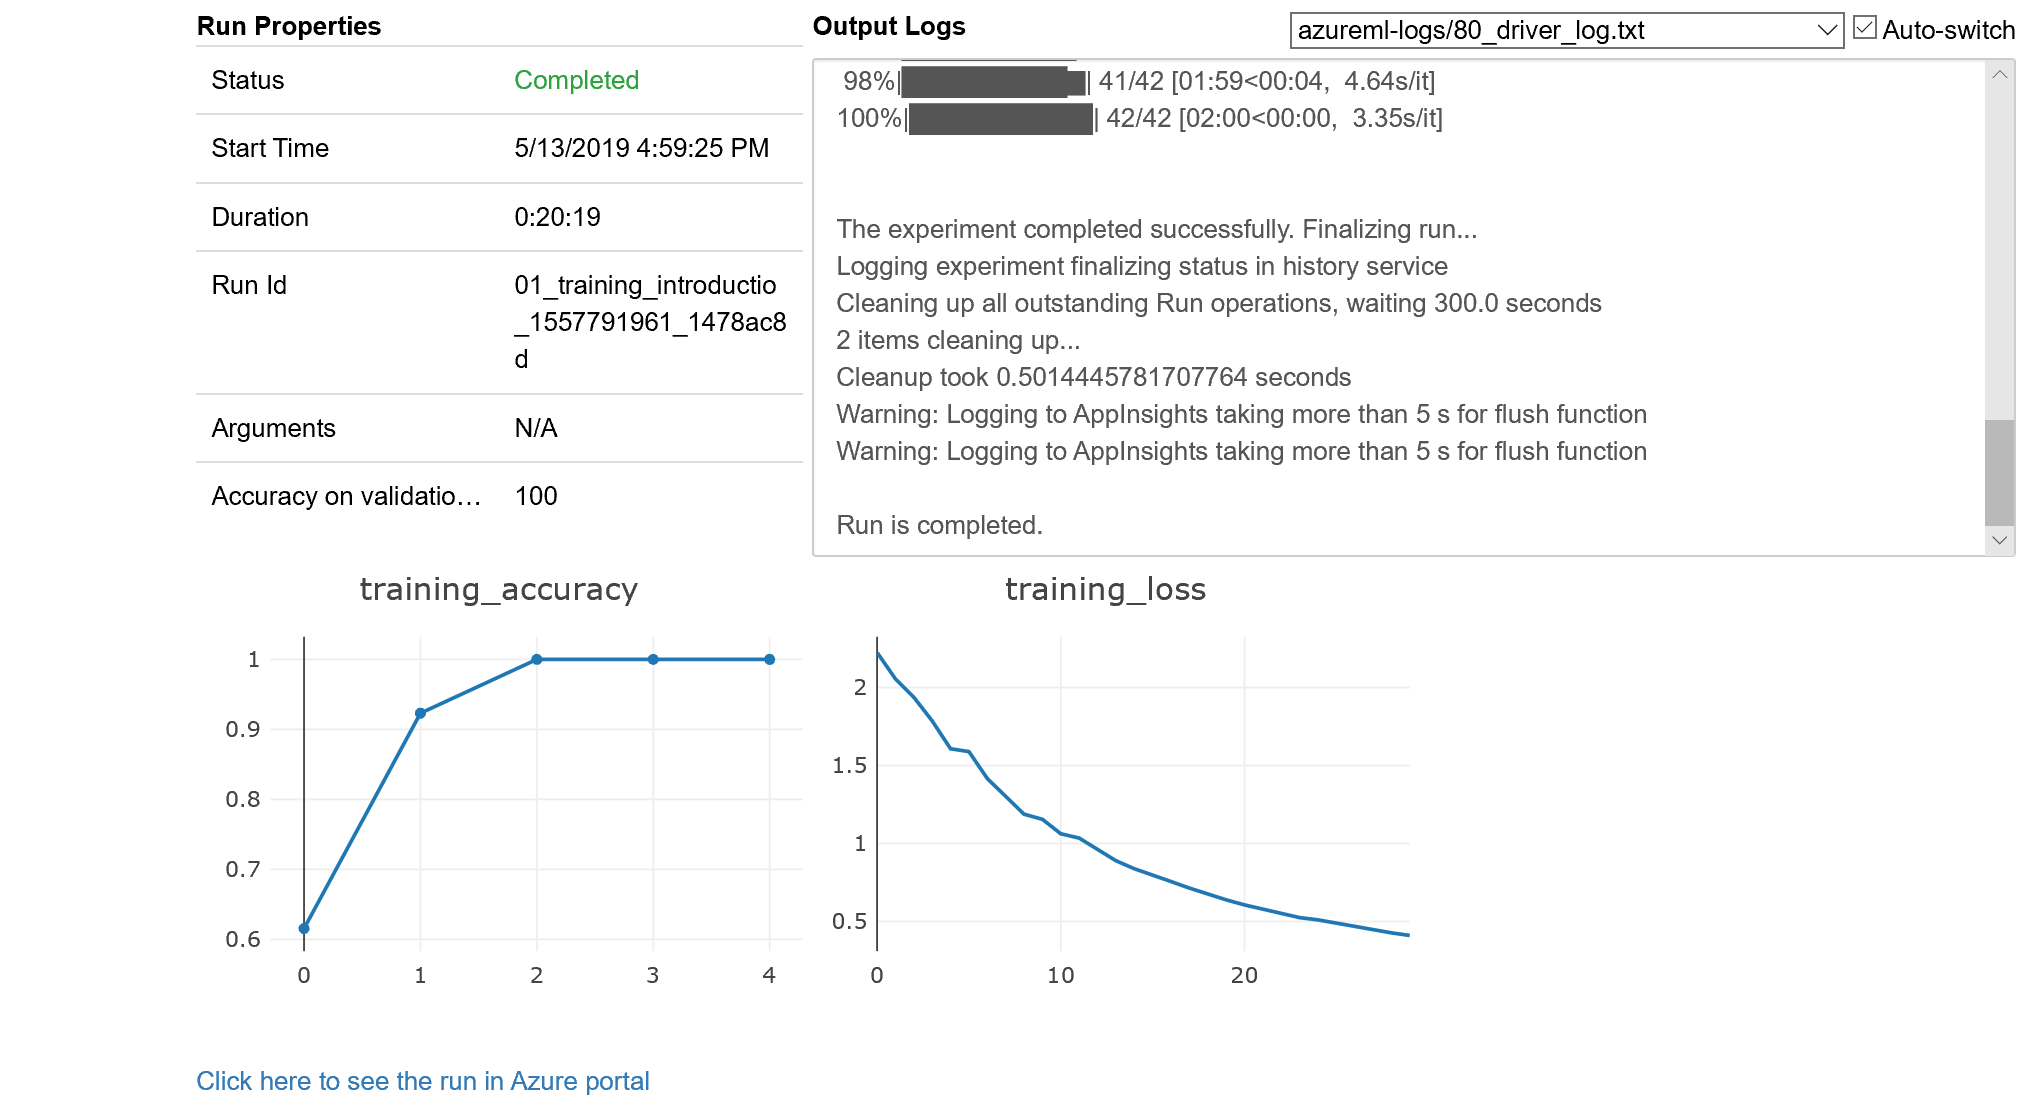

In [9]:
# run below after run is complete, otherwise metrics is empty
metrics = run.get_metrics() # get all metrics logged in the run
print(metrics)

{'Accuracy on validation set:': 100.0, 'training_accuracy': [0.6153846383094788, 0.9230769276618958, 1, 1, 1], 'training_loss': [2.22478985786438, 2.0549919605255127, 1.9374215602874756, 1.7857697010040283, 1.6072492599487305, 1.5886917114257812, 1.4160101413726807, 1.2955670356750488, 1.1876702308654785, 1.154653549194336, 1.0620365142822266, 1.0343571901321411, 0.9593127369880676, 0.8892804384231567, 0.8378573060035706, 0.7999568581581116, 0.7556964159011841, 0.71375572681427, 0.6738472580909729, 0.6384590268135071, 0.6059079766273499, 0.5758486390113831, 0.5488037467002869, 0.5244181156158447, 0.5099084973335266, 0.4878120720386505, 0.4661657512187958, 0.44588702917099, 0.4266100525856018, 0.40978577733039856]}


# Deprovision compute resource
To avoid unnecessary charges, if you created compute target that doesn't scale down to 0, make sure the compute target is deprovisioned after use.
If this notebook took 10 min to run --> cost is less than $10. Refer to the calculator [here](https://azure.microsoft.com/en-us/pricing/calculator/?service=virtual-machines)

In [ ]:
# delete () is used to deprovision and delete the AmlCompute target. 
# do not run below before experiment completes

# compute_target.delete()

# deletion will take a few minutes. You can check progress in Azure Portal / Computing tab